In [ ]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

import xarray as xr

import intake

import sys
sys.path.append("COARE-algorithm/Python/COARE3.5/")  ## importing original meteo and coare35nv modules

# - setting gobal variables once for all
g = 9.81     # m/s2
Lv = 2.5e3   # J/g 
cp = 1.004   # J/g

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
BCO_lon = -59.4288
BCO_lat = 13.1627

print(f"at BCO latitude, 200km correspond to approximately {(180/np.pi)*(200000/(6370000*np.cos(BCO_lat*np.pi/180))):.2f} degrees longitude")

# - set control volume edges
vol_lon = [BCO_lon-0.5+360 , BCO_lon+1.3+360]  #[-60+360, -58+360]
vol_lat = [BCO_lat-0.5     , BCO_lat+1.3]  #[12.5, 14.5]

at BCO latitude, 200km correspond to approximately 1.85 degrees longitude


In [ ]:
## - thanks Lukas
cat = intake.open_catalog("https://gitlab.dkrz.de/data-infrastructure-services/era5-kerchunks/-/raw/main/main.yaml")
ds = cat["surface_analysis_daily"].to_dask()

var_list = ["2t", "2d", "sst", "10u", "10v"]


time_eu = slice("2020-01-01", "2020-02-28")
ds_eu = ds[var_list].sel(time=time_eu)  # [var_list]

mask = ((ds_eu.lon >= vol_lon[0]) & (ds_eu.lon <= vol_lon[1]) &
        (ds_eu.lat >= vol_lat[0]) & (ds_eu.lat <= vol_lat[1])).compute()

cell_indices = np.where(mask)[0]
ds_eu = ds_eu.isel(cell=cell_indices)




time_or = slice("2024-08-01", "2024-10-01")
ds_or = ds[var_list].sel(time=time_or)  # [var_list]

mask = ((ds_or.lon >= vol_lon[0]) & (ds_or.lon <= vol_lon[1]) &
        (ds_or.lat >= vol_lat[0]) & (ds_or.lat <= vol_lat[1])).compute()

cell_indices = np.where(mask)[0]
ds_or = ds_or.isel(cell=cell_indices)



/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


#### to do:
- compute rh with 2d
- find downwelling shortwave and longwave radiation (use BCO)
- put everything in COARE

In [6]:
#### RH computation

from meteo import qsat

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")
# --- SURFACE WEATHER STATION

wxt = cat.BCO.surfacemet_wxt_v1.to_dask()


## EUREC4A
sfc_pressure = wxt['P'].sel(time=time_eu).resample(time='1d').mean().fillna(1013).reindex(time=ds_eu["2d"].time, method='nearest')
sfc_pressure_xr_eu = sfc_pressure.expand_dims(cell=ds_eu["2d"].sizes['cell']).broadcast_like(ds_eu["2d"])

# compute RH at 2m
e  = qsat(ds_eu["2d"].values-273.15, sfc_pressure_xr_eu.values)
es = qsat(ds_eu["2t"].values-273.15, sfc_pressure_xr_eu.values)
rh2_eu = e/es



## ORCESTRA
sfc_pressure = wxt['P'].sel(time=time_or).resample(time='1d').mean().fillna(1013).reindex(time=ds_or["2d"].time, method='nearest')
sfc_pressure_xr_or = sfc_pressure.expand_dims(cell=ds_or["2d"].sizes['cell']).broadcast_like(ds_or["2d"])

# compute RH at 2m
e  = qsat(ds_or["2d"].values-273.15, sfc_pressure_xr_or.values)
es = qsat(ds_or["2t"].values-273.15, sfc_pressure_xr_or.values)
rh2_or = e/es





/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [7]:
## add rh2 to dataset for the Barbados control volume
import xarray as xr

## EUREC4A

ds_eu["rh2"] = xr.DataArray(
    rh2_eu,
    dims=["time", "cell"],
    coords={"time": ds_eu["2d"].time, "cell": ds_eu["2d"].cell},
    attrs={"long_name": "relative humidity at 2m", "units": "dimensionless, [0-1]"}
).chunk(ds_eu["2d"].chunks)



sfc_pressure_xr_eu.attrs.update({
    "description": "daily average surface pressure from BCO",
    "units": "hPa"
})

ds_eu["sfc_pres"] = sfc_pressure_xr_eu.chunk(ds_eu["2d"].chunks)





## ORCESTRA

ds_or["rh2"] = xr.DataArray(
    rh2_or,
    dims=["time", "cell"],
    coords={"time": ds_or["2d"].time, "cell": ds_or["2d"].cell},
    attrs={"long_name": "relative humidity at 2m", "units": "dimensionless, [0-1]"}
).chunk(ds_or["2d"].chunks)



sfc_pressure_xr_or.attrs.update({
    "description": "daily average surface pressure from BCO",
    "units": "hPa"
})

ds_or["sfc_pres"] = sfc_pressure_xr_or.chunk(ds_or["2d"].chunks)

/tmp/ipykernel_186315/30942457.py:11: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
  ).chunk(ds_eu["2d"].chunks)
/tmp/ipykernel_186315/30942457.py:20: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
  ds_eu["sfc_pres"] = sfc_pressure_xr_eu.chunk(ds_eu["2d"].chunks)
/tmp/ipykernel_186315/30942457.py:33: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
  ).chunk(ds_or["2d"].chunks)
/tmp/ipykernel_186315/30942457.py:42: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
  ds_or["sfc_pres"] = sfc_pressure_xr_or.chunk(ds_or["2d"].ch

In [8]:
## get radiation from BCO pyranometers
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")

ds_rad = cat.BCO.radiation_c2_v1.to_dask()
# ds_rad = ds_rad.sel(time=slice("2020-01-01", "2024-09-30"))
ds_rad

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 21GB
Dimensions:       (time: 298415721)
Coordinates:
  * time          (time) datetime64[ns] 2GB 2015-10-15 ... 2026-02-08T23:59:59
    alt           float64 8B ...
    lat           float64 8B ...
    lon           float64 8B ...
Data variables: (12/16)
    LWD_diff      (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    LWD_diff_S    (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    LWD_diff_T    (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    LWD_diff_V    (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    SWD_diff      (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    SWD_diff_S    (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    ...            ...
    SWD_dir_T     (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    SWD_dir_V     (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    SWD_global    (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    SWD_global_S  (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    SWD_global_T  (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
    SWD_global_V  (time) float32 1GB dask.array<chunksize=(262144,), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.12
    bcoproc_version:  0.0.0.post757.dev0+89732e6
    featureType:      timeSeries
    institution:      Max Planck Institute for Meteorology, Hamburg
    license:          CC0-1.0
    location:         The Barbados Cloud Observatory, Deebles Point, Barbados...
    platform:         BCO
    source:           Kipp & Zonen CMP21 (shaded and un-shaded) pyranometer, ...
    summary:          This dataset contains measurements of downwelling short...
    title:            Radiation data from BCO (Level 1)
    tool_versions:    {"Python": "3.11.2 (main, Apr 28 2025, 14:11:48) [GCC 1...

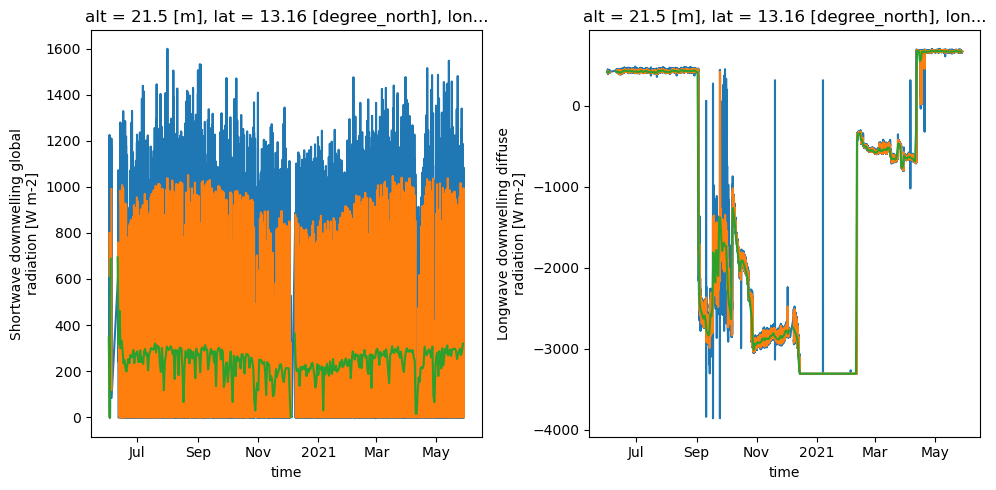

In [61]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

when_here = slice("2020-06-01", "2021-05-28")

ds_rad["SWD_global"].sel(time=when_here).plot(ax=ax[0])
ds_rad["SWD_global"].sel(time=when_here).resample(time="1h").mean().plot(ax=ax[0])
ds_rad["SWD_global"].sel(time=when_here).resample(time="1d").mean().plot(ax=ax[0])

ds_rad["LWD_diff"].sel(time=when_here).plot(ax=ax[1])
ds_rad["LWD_diff"].sel(time=when_here).resample(time="1h").mean().plot(ax=ax[1])
ds_rad["LWD_diff"].sel(time=when_here).resample(time="1d").mean().plot(ax=ax[1])


plt.tight_layout()


In [38]:
## EUREC4A
sw_eu = ds_rad['SWD_global'].sel(time=time_eu).resample(time='1d').mean().fillna(230).reindex(time=ds_eu["2d"].time, method='nearest')
lw_eu = ds_rad["LWD_diff"].sel(time=time_eu).resample(time="1d").mean().fillna(415).reindex(time=ds_eu["2d"].time, method='nearest')

##### actually , between 2020-01-01 and 2020-01-12 , the radiometers were not working #####
##### I impose these mean values here #####
sw_eu.loc[dict(time=slice("2020-01-01", "2020-01-12"))] = 230
lw_eu.loc[dict(time=slice("2020-01-01", "2020-01-12"))] = 415
##### I impose these mean values here #####

sw_xr_eu = sw_eu.expand_dims(cell=ds_eu["2d"].sizes['cell']).broadcast_like(ds_eu["2d"])
lw_xr_eu = lw_eu.expand_dims(cell=ds_eu["2d"].sizes['cell']).broadcast_like(ds_eu["2d"])


## ORCESTRA
sw_or = ds_rad['SWD_global'].sel(time=time_or).resample(time='1d').mean().fillna(250).reindex(time=ds_or["2d"].time, method='nearest')
lw_or = ds_rad["LWD_diff"].sel(time=time_or).resample(time="1d").mean().fillna(430).reindex(time=ds_or["2d"].time, method='nearest')

sw_xr_or = sw_or.expand_dims(cell=ds_or["2d"].sizes['cell']).broadcast_like(ds_or["2d"])
lw_xr_or = lw_or.expand_dims(cell=ds_or["2d"].sizes['cell']).broadcast_like(ds_or["2d"])

In [39]:
## EUREC4A
sw_xr_eu.attrs.update({
    "description": "daily average total SW from BCO",
    "units": "W/m2"
})

lw_xr_eu.attrs.update({
    "description": "daily average diffuse LW from BCO",
    "units": "W/m2"
})

ds_eu["sw_global"] = sw_xr_eu.chunk(ds_eu["2d"].chunks)
ds_eu["lw_diff"]   = lw_xr_eu.chunk(ds_eu["2d"].chunks)


## ORCESTRA
sw_xr_or.attrs.update({
    "description": "daily average total SW from BCO",
    "units": "W/m2"
})

lw_xr_or.attrs.update({
    "description": "daily average diffuse LW from BCO",
    "units": "W/m2"
})

ds_or["sw_global"] = sw_xr_or.chunk(ds_or["2d"].chunks)
ds_or["lw_diff"]   = lw_xr_or.chunk(ds_or["2d"].chunks)

/tmp/ipykernel_186315/1901093870.py:12: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
  ds_eu["sw_global"] = sw_xr_eu.chunk(ds_eu["2d"].chunks)
/tmp/ipykernel_186315/1901093870.py:13: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
  ds_eu["lw_diff"]   = lw_xr_eu.chunk(ds_eu["2d"].chunks)
/tmp/ipykernel_186315/1901093870.py:27: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
  ds_or["sw_global"] = sw_xr_or.chunk(ds_or["2d"].chunks)
/tmp/ipykernel_186315/1901093870.py:28: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
  ds_o

In [40]:
ds_eu.lon.attrs.update({
    "filter_by_keys": ""
})

ds_eu.lat.attrs.update({
    "filter_by_keys": ""
})

ds_or.lon.attrs.update({
    "filter_by_keys": ""
})

ds_or.lat.attrs.update({
    "filter_by_keys": ""
})

ds_or

<xarray.Dataset> Size: 155kB
Dimensions:    (time: 61, cell: 42)
Coordinates:
  * time       (time) datetime64[ns] 488B 2024-08-01T11:30:00 ... 2024-09-30T...
  * cell       (cell) int64 336B 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
    lat        (cell) float64 336B dask.array<chunksize=(42,), meta=np.ndarray>
    lon        (cell) float64 336B dask.array<chunksize=(42,), meta=np.ndarray>
    alt        float64 8B ...
Data variables:
    2t         (time, cell) float64 20kB dask.array<chunksize=(6, 42), meta=np.ndarray>
    2d         (time, cell) float64 20kB dask.array<chunksize=(6, 42), meta=np.ndarray>
    sst        (time, cell) float64 20kB dask.array<chunksize=(6, 42), meta=np.ndarray>
    10u        (time, cell) float64 20kB dask.array<chunksize=(6, 42), meta=np.ndarray>
    10v        (time, cell) float64 20kB dask.array<chunksize=(6, 42), meta=np.ndarray>
    rh2        (time, cell) float64 20kB dask.array<chunksize=(6, 42), meta=np.ndarray>
    sfc_pres   (time, cell) float32 10kB dask.array<chunksize=(6, 42), meta=np.ndarray>
    sw_global  (time, cell) float32 10kB dask.array<chunksize=(6, 42), meta=np.ndarray>
    lw_diff    (time, cell) float32 10kB dask.array<chunksize=(6, 42), meta=np.ndarray>
Attributes: (12/22)
    project:              ECMWF Re-Analysis
    project_id:           ERA
    institution_id:       ECMWF-DKRZ
    institution:          Data from European Centre for Medium-Range Weather ...
    source_id:            IFS
    source:               ECMWF Integrated Forecast System (IFS) CY41R2
    ...                   ...
    format:               kerchunk
    product:              reanalysis
    responsible_persons:  Angelika Heil, Fabian Wachsmann
    title:                The DKRZ ERA5 data pool. Generated using Copernicus...
    license:              The ERA5 data are published with the Copernicus Pro...
    references:           Hersbach, H., Bell, B., Berrisford, P., Hirahara, S...

In [42]:
## EUREC4A
encoding = {}

for var in ds_eu.data_vars:
    if ds_eu[var].chunks:
        encoding[var] = {
            "chunksizes": [c[0] for c in ds_eu[var].chunks]
        }

ds_eu.to_netcdf(
    "fluxes_data/EUREC4A_IngrFlux.nc",
    engine="netcdf4",
    mode="w",
    encoding=encoding
)



In [43]:
## ORCESTRA
encoding = {}

for var in ds_or.data_vars:
    if ds_or[var].chunks:
        encoding[var] = {
            "chunksizes": [c[0] for c in ds_or[var].chunks]
        }

ds_or.to_netcdf(
    "fluxes_data/ORCESTRA_IngrFlux.nc",
    engine="netcdf4",
    mode="w",
    encoding=encoding
)



#### check my inputs

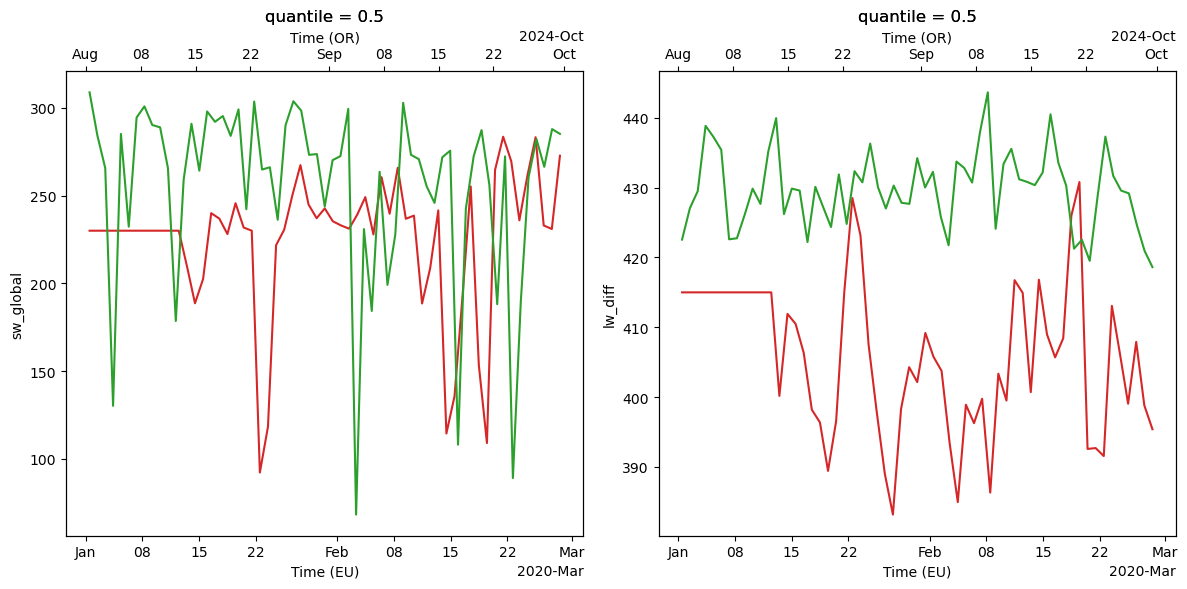

In [41]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))


# --- Base plot (EU) ---
ds_eu.sw_global.quantile(0.5, dim="cell").plot.line(
    ax=ax[0],
    x="time",
    color="tab:red",
    label="EU"
)

# --- Create secondary axes ---
ax_top = ax[0].twiny()  # right y-axis

# --- Plot OR data on secondary axes ---
ds_or.sw_global.quantile(0.5, dim="cell").plot.line(
    ax=ax_top,
    x="time",
    color="tab:green",
    label="OR"
)

# --- Axis labels (important, otherwise it's confusing) ---
ax[0].set_xlabel("Time (EU)")
ax[0].set_ylabel("sw_global")

ax_top.set_xlabel("Time (OR)")



###### LW ######

# --- Base plot (EU) ---
ds_eu.lw_diff.quantile(0.5, dim="cell").plot.line(
    ax=ax[1],
    x="time",
    color="tab:red",
    label="EU"
)

# --- Create secondary axes ---
ax_top = ax[1].twiny()  # right y-axis

# --- Plot OR data on secondary axes ---
ds_or.lw_diff.quantile(0.5, dim="cell").plot.line(
    ax=ax_top,
    x="time",
    color="tab:green",
    label="OR"
)

# --- Axis labels (important, otherwise it's confusing) ---
ax[1].set_xlabel("Time (EU)")
ax[1].set_ylabel("lw_diff")

ax_top.set_xlabel("Time (OR)")


plt.tight_layout()
plt.show()

#### computation of surface fluxes from ERA5 large scale fields

In [ ]:
import coare35vn

ingredients_eu = xr.open_dataset("fluxes_data/EUREC4A_IngrFlux.nc")
ingredients_or = xr.open_dataset("fluxes_data/ORCESTRA_IngrFlux.nc")

In [ ]:
ingredients_or

In [4]:
## subselect some data for quick look
time_window = ingredients_eu.time
u10, v10 = ingredients_eu["10u"].sel(time=time_window), ingredients_eu["10v"].sel(time=time_window)
u = (u10**2 + v10**2)**0.5
t = ingredients_eu["2t"].sel(time=time_window)
rh = ingredients_eu["rh2"].sel(time=time_window)
ts = ingredients_eu["sst"].sel(time=time_window)
P = ingredients_eu["sfc_pres"].sel(time=time_window)
Rs = ingredients_eu["sw_global"].sel(time=time_window)
Rl = ingredients_eu["lw_diff"].sel(time=time_window)

output_eu = coare35vn.coare35vn(u=u.values.flatten(),
                             t=t.values.flatten()-273.15,
                             rh=100*rh.values.flatten(),
                             ts=ts.values.flatten()-273.15,
                             P=P.values.flatten(),
                             Rs=Rs.values.flatten(),
                             Rl=Rl.values.flatten(), 
                             zu=10, zt=2, zq=2, lat=13, zi=600, rain=None, cp=None, sigH=None, jcool=1)




time_window = ingredients_or.time
u10, v10 = ingredients_or["10u"].sel(time=time_window), ingredients_or["10v"].sel(time=time_window)
u = (u10**2 + v10**2)**0.5
t = ingredients_or["2t"].sel(time=time_window)
rh = ingredients_or["rh2"].sel(time=time_window)
ts = ingredients_or["sst"].sel(time=time_window)
P = ingredients_or["sfc_pres"].sel(time=time_window)
Rs = ingredients_or["sw_global"].sel(time=time_window)
Rl = ingredients_or["lw_diff"].sel(time=time_window)

output_or = coare35vn.coare35vn(u=u.values.flatten(),
                             t=t.values.flatten()-273.15,
                             rh=100*rh.values.flatten(),
                             ts=ts.values.flatten()-273.15,
                             P=P.values.flatten(),
                             Rs=Rs.values.flatten(),
                             Rl=Rl.values.flatten(), 
                             zu=10, zt=2, zq=2, lat=13, zi=600, rain=None, cp=None, sigH=None, jcool=1)

## output
# list1 = [usr,tau,hsb,hlb,hbb,hlwebb,tsr,qsr,zot,zoq,Cd,Ch,Ce,L,zet, dter,dqer,tkt,RF,Cdn_10,Chn_10,Cen_10]
        #    usr,tau,hsb,hlb,hbb,hlwebb,tsr,qsr,zot,zoq,Cd,Ch,Ce,L,zet, dter,dqer,tkt,RF,Cdn_10,Chn_10,Cen_10
# 0      usr     friction velocity that includes gustiness (m/s)


#     1      tau     wind stress (N/m^2)


#     2      hsb     sensible heat flux into ocean (W/m^2)


#     3      hlb     latent heat flux into ocean (W/m^2)


#     4      hbb     buoyancy flux into ocean (W/m^2)

#     6      hlwebb  Webb correction for latent heat flux, add this to directly

#     7      tsr     temperature scaling parameter (K)


#     8      qsr     specific humidity scaling parameter (g/Kg)


#     9      zot     thermal roughness length (m)


#     10     zoq     moisture roughness length (m)


    # 11     Cd      wind stress transfer (drag) coefficient at height zu


    # 12     Ch      sensible heat transfer coefficient (Stanton number) at ht zu


    # 13     Ce      latent heat transfer coefficient (Dalton number) at ht zq


    # 14     L       Obukhov length scale (m)


    # 15     zet     Monin-Obukhov stability parameter zu/L


    # 16     dter    cool-skin temperature depression (degC)


    # 17     dqer    cool-skin humidity depression (degC)


    # 18     tkt     cool-skin thickness (m)

    # 33     RF      rain heat flux (W/m2)

    # 30     Cdn_10  neutral value of drag coefficient at 10m


    # 31     Chn_10  neutral value of Stanton number at 10m


    # 32     Cen_10  neutral value of Dalton number at 10m




/work/mh1498/m301248/TCO_data/COARE-algorithm/Python/COARE3.5/meteo.py:156: RuntimeWarning: invalid value encountered in power
  psi = -((1 + 0.6667*zet)**1.5 + 0.6667*(zet - 14.28)*exp(-dzet) + 8.525)


In [5]:
sfc_fluxes_eu = xr.Dataset()
sfc_fluxes_or = xr.Dataset()

variables = {"names":["usr","tau","shf","lhf","hbb","hlwebb","tsr","qsr","zot","zoq","Cd","Ch","Ce",
                      "L","zet", "dter","dqer","tkt","RF","Cdn_10","Chn_10","Cen_10", "cqhf", "dq_wetc", "wetc*dter*jcool", "wetc"],
             


             "description": ["friction velocity that includes gustiness", 
                             "wind stress", 
                             "sensible heat flux into ocean",
                            "latent heat flux into ocean" ,
                            "buoyancy flux into ocean",
                            "Webb correction for latent heat flux, add this to directly",
                            "temperature scaling parameter",
                            "specific humidity scaling parameter",
                             "thermal roughness length", 
                            "moisture roughness length",
                            "wind stress transfer (drag) coefficient at height zu",
                            "sensible heat transfer coefficient (Stanton number) at ht zu",
                            "latent heat transfer coefficient (Dalton number) at ht zq",
                            "Obukhov length scale",
                            "Monin-Obukhov stability parameter zu/L",
                            "cool-skin temperature depression",
                            "cool-skin humidity depression",
                            "cool-skin thickness",
                            "rain heat flux ",
                            "neutral value of drag coefficient at 10m",
                            "neutral value of Stanton number at 10m",
                            "neutral value of Dalton number at 10m", 
                            "moisture exchange coeff", 
                            "dq - wetc*dter*jcool", 
                            "wetc*dter*jcool",
                            "wetc_only" ,
                            "dter only"], 
                 "units": [ "m/s",
                            "N/m^2",
                            "W/m^2",
                            "W/m^2",
                            "W/m^2",
                            "correction",
                            "K",
                            "g/Kg",
                            "m",
                            "m",
                            "coefficient",
                            "number",
                            "number",
                            "m",
                            "parameter",
                            "degC",
                            "degC",
                            "m",
                            "W/m2",
                            "coefficient",
                            "number",
                            "number", 
                            "number", 
                            "number", 
                            "number", 
                            "number",]
                            
            }

for j in range(output_eu.shape[1]):
    var = output_eu[:,j]
    var = var.reshape(59, 42)

    da = xr.DataArray(
        var,
        dims=("time", "cell"),
        coords={
            "time": ingredients_eu.time.values,
            "cell": np.arange(42),
            "lat": ("cell", ingredients_eu.lat.values),
            "lon": ("cell", ingredients_eu.lon.values),
        },
        attrs={
        "units": variables["units"][j],
        "description": variables["description"][j]
        },

        name=variables["names"][j]
                )
    
    sfc_fluxes_eu[variables["names"][j]] = da



for j in range(output_or.shape[1]):
    var = output_or[:,j]
    var = var.reshape(61, 42)

    da = xr.DataArray(
        var,
        dims=("time", "cell"),
        coords={
            "time": ingredients_or.time.values,
            "cell": np.arange(42),
            "lat": ("cell", ingredients_or.lat.values),
            "lon": ("cell", ingredients_or.lon.values),
        },
        attrs={
        "units": variables["units"][j],
        "description": variables["description"][j]
        },

        name=variables["names"][j]
                )
    
    sfc_fluxes_or[variables["names"][j]] = da

In [50]:
sfc_fluxes_eu.to_netcdf("fluxes_data/sfcFluxes_EUREC4A.nc")
sfc_fluxes_or.to_netcdf("fluxes_data/sfcFluxes_ORCESTRA.nc")

### Analyze variability of data

In [6]:
sfc_fluxes_eu = xr.open_dataset("fluxes_data/sfcFluxes_EUREC4A.nc")
sfc_fluxes_or = xr.open_dataset("fluxes_data/sfcFluxes_ORCESTRA.nc")

Text(0.5, 1.0, '')

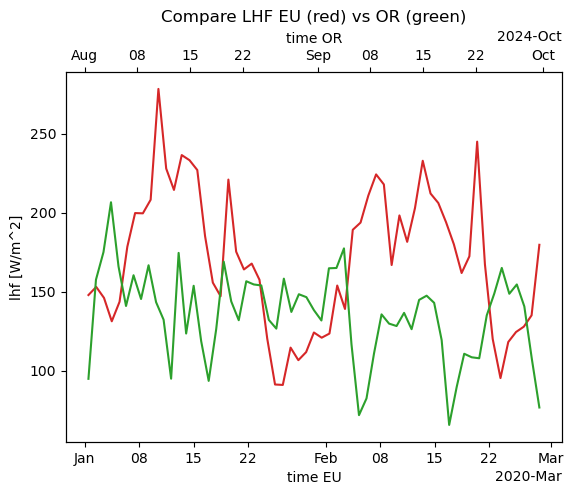

In [7]:
fig, ax = plt.subplots(1,1)

sfc_fluxes_eu.lhf.quantile(0.5, dim="cell").plot.line(
    ax=ax,
    x="time",
    color="tab:red",
    label="EU"
)
ax.set_xlabel("time EU")

# --- Create secondary axes ---
ax_top = ax.twiny()  # right y-axis

# --- Plot OR data on secondary axes ---
sfc_fluxes_or.lhf.quantile(0.5, dim="cell").plot.line(
    ax=ax_top,
    x="time",
    color="tab:green",
    label="OR"
)
ax_top.set_xlabel("time OR")

ax.set_title("Compare LHF EU (red) vs OR (green)")
ax_top.set_title("")

#### compare with measurements from R/V

## TO DO : select only data whn ships are within the control volume

In [25]:
## open data from EUREC4A
meteor_eu = xr.open_dataset("EUREC4A_rv/EUREC4A_Meteor_surface_heat_fluxes_20200115_v1.0.nc")
meteor_eu

<xarray.Dataset> Size: 371kB
Dimensions:                      (time: 2016, nbnds: 2)
Coordinates:
  * time                         (time) datetime64[ns] 16kB 2020-01-15 ... 20...
Dimensions without coordinates: nbnds
Data variables: (12/41)
    lat                          (time) float32 8kB ...
    lon                          (time) float32 8kB ...
    time_bnds                    (time, nbnds) datetime64[ns] 32kB ...
    SHF_EC_mast                  (time) float32 8kB ...
    SHF_bulk_mast                (time) float32 8kB ...
    LHF_EC_mast                  (time) float32 8kB ...
    ...                           ...
    mask_despiking_T_mast        (time) float32 8kB ...
    mask_despiking_Z_mast        (time) float32 8kB ...
    mask_data_availability_mast  (time) float32 8kB ...
    mask_vsea_bulk_mast          (time) float32 8kB ...
    mask_vsea_bulk_bow           (time) float32 8kB ...
    mask_LHF_EC_bow_transit      (time) float32 8kB ...
Attributes:
    title:           Eddy-Covariance and bulk turbulent surface fluxes averag...
    history:         Created 21-09-21
    institution:     Meteorological Institute, Universitaet Hamburg
    contact_person:  Imke Schirmacher (imke.schirmacher@uni-koeln.de), Ingo L...
    source:          Ultra-Sonic Anemometer/Thermometer METEK uSonic-3 Scient...
    comments:        The surface fluxes are processed and flagged (nan) by th...
    authors:         Schirmacher, Imke; Lange, Ingo

In [60]:
## open Meteor data from ORCESTRA
meteor_or = xr.open_dataset("ipfs://bafybeib5awa3le6nxi4rgepn2mwxj733aazpkmgtcpa3uc2744gxv7op44", engine="zarr")


time_window = slice( '2024-08-14', '2024-09-23' ) #meteor_or.time
u = meteor_or.wspd_rel.sel(time=time_window)
t = meteor_or.t_air_port.sel(time=time_window)
rh = meteor_or.rh_port.sel(time=time_window)
ts = meteor_or.sst_port.sel(time=time_window)
P = meteor_or.p_air.sel(time=time_window)
Rs = meteor_or.swr.sel(time=time_window)
Rl = meteor_or.lwr.sel(time=time_window)

output_meteor_or = coare35vn.coare35vn(u=u.values.flatten(),
                             t=t.values.flatten()-273.15,
                             rh=rh.values.flatten(),
                             ts=ts.values.flatten()-273.15,
                             P=P.values.flatten()/100.,
                             Rs=Rs.values.flatten(),
                             Rl=Rl.values.flatten(), 
                             zu=28, zt=28, zq=28, lat=13, zi=600, rain=None, cp=None, sigH=None, jcool=1)


lhf_meteor_or = xr.DataArray(
        output_meteor_or[:,3],
        dims=("time"),
        coords={
            "time": meteor_or.sel(time=time_window).time.values,
            "lat":  ("time",meteor_or.sel(time=time_window).lat.values),
            "lon":  ("time",meteor_or.sel(time=time_window).lon.values),
        },
        attrs={
        "units": "W/m2",
        "description": "bulk reconstruction of Meteor OR LHF"
        },

        name="LHF"
                )

shf_meteor_or = xr.DataArray(
        output_meteor_or[:,2],
        dims=("time"),
        coords={
            "time": meteor_or.sel(time=time_window).time.values,
            "lat":  ("time",meteor_or.sel(time=time_window).lat.values),
            "lon":  ("time",meteor_or.sel(time=time_window).lon.values),
        },
        attrs={
        "units": "W/m2",
        "description": "bulk reconstruction of Meteor OR SHF"
        },

        name="SHF"
                )

/work/mh1498/m301248/TCO_data/COARE-algorithm/Python/COARE3.5/meteo.py:156: RuntimeWarning: invalid value encountered in power
  psi = -((1 + 0.6667*zet)**1.5 + 0.6667*(zet - 14.28)*exp(-dzet) + 8.525)


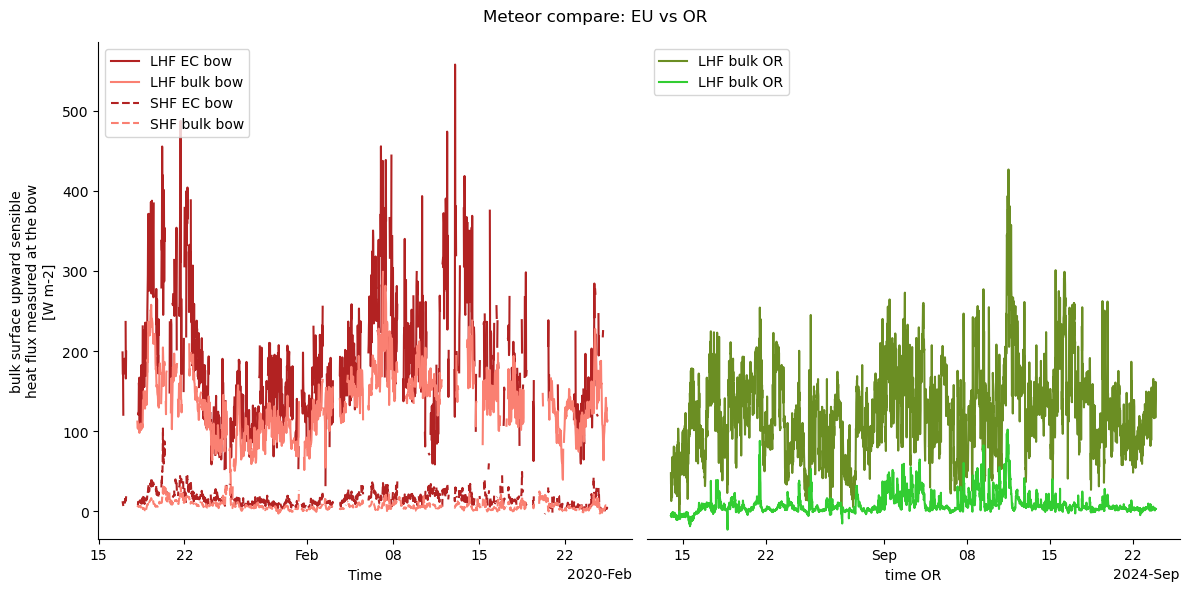

In [61]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
fig.suptitle("Meteor compare: EU vs OR")

## lhf eurec4a
meteor_eu.LHF_EC_bow.plot.line(ax=ax[0], x="time", label="LHF EC bow", color="firebrick")
meteor_eu.LHF_bulk_bow.plot.line(ax=ax[0], x="time", label="LHF bulk bow", color="salmon")
ax[0].set_xlabel("time EU")

## shf eurec4a
meteor_eu.SHF_EC_bow.plot.line(ax=ax[0], x="time", label="SHF EC bow", color="firebrick", linestyle="dashed")
meteor_eu.SHF_bulk_bow.plot.line(ax=ax[0], x="time", label="SHF bulk bow", color="salmon", linestyle="dashed")
ax[0].legend(loc="upper left")



## lhf orcestra
lhf_meteor_or[::15].plot.line(ax=ax[1], x="time", label="LHF bulk OR", color="olivedrab")
ax[1].set_xlabel("time OR")

## shf orcestra
shf_meteor_or[::15].plot.line(ax=ax[1], x="time", label="LHF bulk OR", color="limegreen")

ax[1].legend(loc="upper left")

ax[1].set_xlabel("time OR")
ax[1].spines["left"].set_visible(False)
ymin, ymax = ax[0].get_ylim()
ax[1].set_ylim(ymin, ymax)
ax[1].yaxis.set_visible(False)



for x in ax:
    for spine in ['top', 'right']:
            x.spines[spine].set_visible(False)

plt.tight_layout()

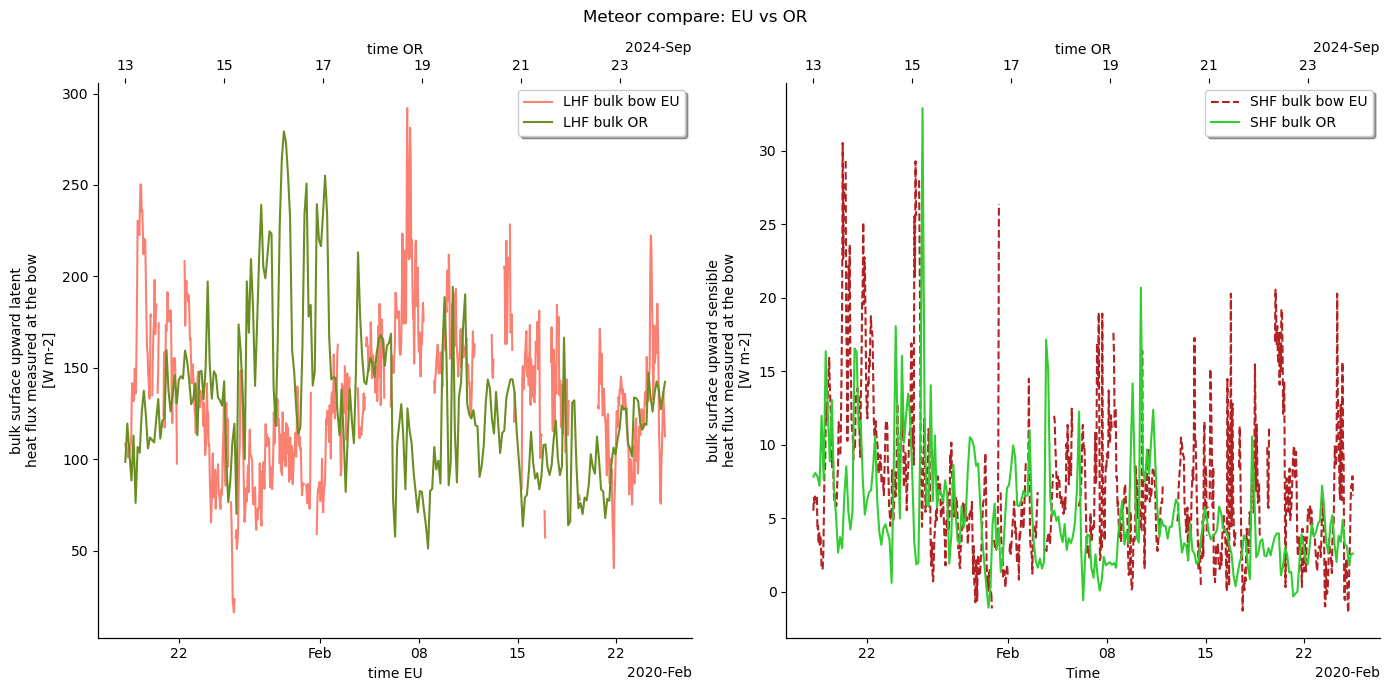

In [52]:
fig, ax = plt.subplots(1,2, figsize=(14, 7))
fig.suptitle("Meteor compare: EU vs OR")

## lhf eurec4a
# meteor_eu.LHF_EC_bow.plot.line(ax=ax[0], x="time", label="LHF EC bow", color="firebrick")
meteor_eu.LHF_bulk_bow.resample(time="1h").mean().plot.line(ax=ax[0], x="time", label="LHF bulk bow EU", color="salmon")
ax[0].set_xlabel("time EU")

## lhf orcestra
ax1 = ax[0].twiny()
lhf_meteor_or.resample(time="1h").mean().plot.line(ax=ax1, x="time", label="LHF bulk OR", color="olivedrab")
ax1.set_xlabel("time OR")

# Collect all handles and labels from both axes
lines1, labels1 = ax[0].get_legend_handles_labels()
lines2, labels2 = ax1.get_legend_handles_labels()

# Combine them
all_lines = lines1 + lines2
all_labels = labels1 + labels2

# Create a single legend on ax[0]
ax[0].legend(all_lines, all_labels, loc='upper right', frameon=True, fancybox=True, shadow=True)






## shf eurec4a
# meteor_eu.SHF_EC_bow.plot.line(ax=ax[1], x="time", label="SHF EC bow", color="firebrick", linestyle="dashed")
meteor_eu.SHF_bulk_bow.resample(time="1h").mean().plot.line(ax=ax[1], x="time", label="SHF bulk bow EU", color="firebrick", linestyle="dashed")

## shf orcestra
ax2 = ax[1].twiny()
shf_meteor_or.resample(time="1h").mean().plot.line(ax=ax2, x="time", label="SHF bulk OR", color="limegreen")
ax2.set_xlabel("time OR")

# Collect all handles and labels from both axes
lines1, labels1 = ax[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Combine them
all_lines = lines1 + lines2
all_labels = labels1 + labels2

# Create a single legend on ax[0]
ax[1].legend(all_lines, all_labels, loc='upper right', frameon=True, fancybox=True, shadow=True)



for x in [ax[0], ax[1], ax1, ax2]:
    for spine in ['top', 'right']:
            x.spines[spine].set_visible(False)

plt.tight_layout()